Maybe easier to follow https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot%20tutorial

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
import numpy as np
from io import open
import itertools
import math
import matplotlib.pyplot as plt
%matplotlib inline


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [2]:
print(device)

cpu


In [3]:
corpus_name = "cornell movie-dialogs corpus"
corpus = os.path.join("../dat/", corpus_name)

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

#printLines(os.path.join(corpus, "movie_lines.txt"))


In [4]:
# Splits each line of the file into a dictionary of fields
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs


# Extracts cleaned dialogue sentences from conversations
def extractConversation(conversations):
    clean_conversation = []
    for conversation in conversations:
        convo = []
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"])):  # We ignore the last line (no answer for it)
            Line = conversation["lines"][i]["text"].strip()
            convo.append(Line)
        if len(convo) > 2: #there has to be a reply? 
            clean_conversation.append(convo)

    return clean_conversation

In [5]:
# Define path to new file

datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# Load lines and process conversations
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

convos = extractConversation(conversations)
# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)


    


Processing corpus...

Loading conversations...

Writing newly formatted file...


In [6]:
# Little bit of eda.. 
convo_lengths = []
utterance_lengths = []
for convo in convos:
    conversation_length = len(convo)
    if conversation_length > 2:
 #       print(convo)
        convo_lengths.append(conversation_length)
        for sentence in convo:
            utterance_lengths.append(len(sentence.split(' ')))

Text(0, 0.5, 'Frequency')

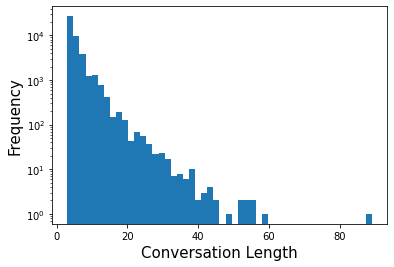

In [7]:
plt.hist(convo_lengths,bins=50)
plt.yscale('log')
plt.xlabel('Conversation Length',fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)

Text(0, 0.5, 'Frequency')

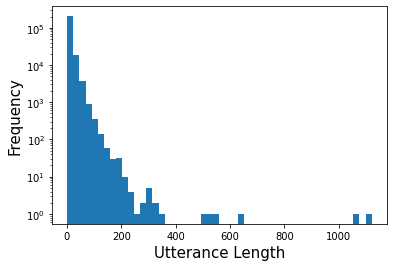

In [8]:
plt.hist(utterance_lengths,bins=50)
plt.yscale('log')
plt.xlabel('Utterance Length',fontsize = 15)
plt.ylabel("Frequency",fontsize = 15)

In [9]:
class DialogEnvironment(object):
    """
    
    Gym environment for dialog.
    
    """
    def __init__(self, mode='train'):
        

        self.conversations = extractConversation(conversations)
        
    
        if mode == 'train':
            self.conversations = self.conversations[:-10]
        elif mode == 'test':
            self.conversations = self.conversations[-10]
            
        
        self.conversations_visited = []
        
    def clear(self):
        self.conversations_visited = [] #
    def current_state(self):
        return i,j # i for current conversation index, j for current word (these should be odd? )
    
    def reset(self):
        # pick a random i in length of convos. If in convos visited, skip
        
        self.i = random.randint(a=0,b=len(self.conversations))
        
        
        self.conversations_visited.append(self.i)
        self.conversation = self.conversations[self.i]
        self.j = 0
        state = self.conversation[self.j]
        return state
    def step(self,action):
        done = False
        self.j +=2 
        new_state = self.conversation[self.j]
        
        if new_state in self.conversation[-2:]: # if this last obs was either the last or second last thing, end here. 
            done = True
        
        return new_state, done


In [10]:
env = DialogEnvironment()

In [11]:
i = 0
while i < 5:
    state  = env.reset()
    print("~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~")
    print('first state : ', state)
    while True:
     #   action = "Fuck that, I'm not even supposed to be here "
        action = env.conversation[env.j - 1] #it's already a part of the env,
        print("agent action : ", action)
        new_state, done = env.step(action)
#        print("agent action : ", expert_action, env.j)
        print("next state : ", new_state)
        if done:
            break

    i += 1

~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  You think I love Jessica and want her back. It is like you to think that -- clean, decent thinking.
agent action :  I hated her.
next state :  I hated her.
~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  My, my. You have exceeded my expectations.
agent action :  No, sir. Plainly put, I never expect to sleep again.
next state :  How is the patient faring?
agent action :  And my own.
next state :  And you? It must've been an ordeal.
agent action :  Poorly.
next state :  Will you sleep soundly tonight?
~~~~~~~~~~~~~~~~~ New Episode ~~~~~~~~~~~~~~
first state :  Knock knock.
agent action :  Monkey, this is too exciting! I can't believe our dream is coming true.
next state :  Guess what"s under these coconuts.
agent action :  Who's there?
next state :  It's a surprise.
agent action :  What?
next state :  You got the Extender?
agent action :  Well I've got a little surprise for you.
next state :  Monkey, this is too exci

# TODO:

Get the word embeddings for these sentences. Should there be padding? If it's fixed sequence, may be easier to train on.

After that's all figured out, conduct IRL. 

sequence length = 20: 

=> -- some fine tuned word language model, getting the best representation possible for this corpus

Why are you laughing? => [1x200, 1x200, 1x200 1x200 , 1x200,   .... MAX_LENGTH] , some form of token padding 

rather than vectorized form, 

the network always aceepts the same input shape, which here is like [ Maxlengnth x 1 x 200]

from this, it emits an action, which is then [action_maxlenth x 1 x 200]


using the action, the environment then emits the new state, of dimension [ Maxlengnth x 1 x 200]


So how does RL come into play here? 


Even though the environment above is fixed,we know how the "expert" behaves when running through it. 




GAIL: 



# Dummy Embeddings

## Using https://github.com/YuriyGuts/thrones2vec/blob/master/Thrones2Vec.ipynb

In [21]:
from __future__ import absolute_import, division, print_function
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [22]:
# Download tokenizer model
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/nsk367/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/nsk367/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Prepare Corpus

In [33]:
corpus_raw = " ".join([" ".join(i) for i in convos])

In [35]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


In [36]:
raw_sentences = tokenizer.tokenize(corpus_raw)


In [37]:
raw_sentences

['Can we make this quick?',
 'Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.',
 'Again.',
 "Well, I thought we'd start with pronunciation, if that's okay with you.",
 'Not the hacking and gagging and spitting part.',
 'Please.',
 "Okay... then how 'bout we try out some French cuisine.",
 'Saturday?',
 'Night?',
 "No, no, it's my fault -- we didn't have a proper introduction --- Cameron.",
 "The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.",
 'My sister.',
 "I can't date until she does.",
 'Seems like she could get a date easy enough... Why?',
 'Unsolved mystery.',
 'She used to be really popular when she started high school, then it was just like she got sick of it or something.',
 "That's a shame.",
 "C'esc ma tete.",
 'This is my head Right.',
 'See?',
 "You're ready for the quiz.",
 "I don't want to know how to say that though.",
 'I want to know useful things.',
 'Like where the good stores are

In [40]:

def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [41]:

sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [43]:
print(raw_sentences[131])
print(sentence_to_wordlist(raw_sentences[131]))

Let go!
['Let', 'go']


In [44]:
token_count = sum([len(sentence) for sentence in sentences])
print("The cornell dialog corpus contains {0:,} tokens".format(token_count))

The cornell dialog corpus contains 2,617,175 tokens


## Train Word2Vec

In [45]:

# Dimensionality of the resulting word vectors.
num_features = 300

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [46]:
cornell2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [47]:
cornell2vec.build_vocab(sentences)


In [50]:
print("Word2Vec vocabulary length:", len(cornell2vec.wv.vocab)) # old version on github, had to add .wv


Word2Vec vocabulary length: 23627


### Start training ~ min or two

In [52]:
len(raw_sentences)

371392

In [55]:
cornell2vec.train(sentences,total_examples=len(sentences),epochs=10) # another update, I added num sentences and n epochs


(19146205, 26171750)

### Choosing not to save since it's pretty hacky for now, but I will now explore the semantics, and explore how you insert this into the environment.

In [56]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)


In [58]:
all_word_vectors_matrix = cornell2vec.wv.syn0 # again updated, use .wv


<ipython-input-58-b32890fdb609>:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  all_word_vectors_matrix = cornell2vec.wv.syn0 # again updated, use .wv


In [60]:
all_word_vectors_matrix.shape

(23627, 300)

In [61]:

# Train TSNE, wait a while... 
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)


In [64]:
# plot it all 

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[cornell2vec.wv.vocab[word].index])
            for word in cornell2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [65]:
points.head(10)


,word,x,y
0,Can,-14.161529,-39.966572
1,we,15.454491,-16.249889
2,make,-4.526019,-36.154564
3,this,-3.093258,-21.197485
4,quick,-2.888600,-26.978487
5,and,23.914825,-12.229586
6,Andrew,-29.262428,-2.256632
7,Barrett,-34.535904,-11.395054
8,are,-17.901049,-23.677544
9,having,-52.329987,19.434158


In [66]:
sns.set_context("poster")


<AxesSubplot:xlabel='x', ylabel='y'>

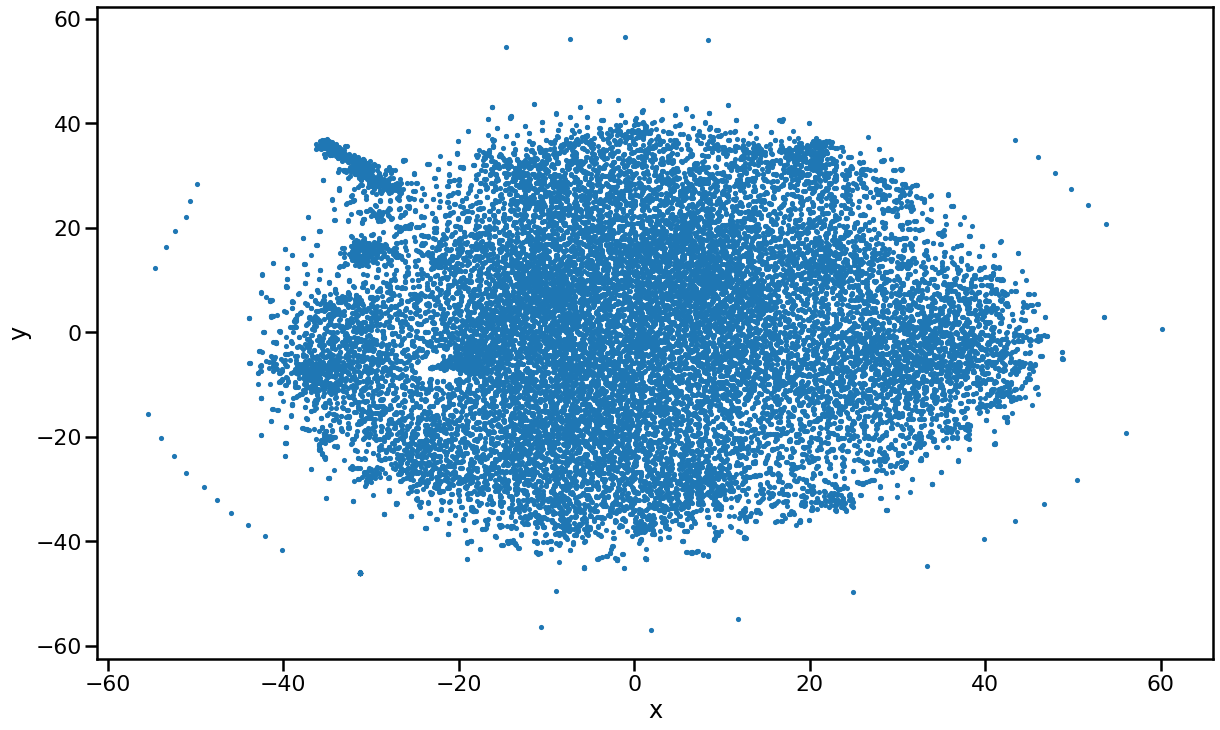

In [67]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))


In [68]:

def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

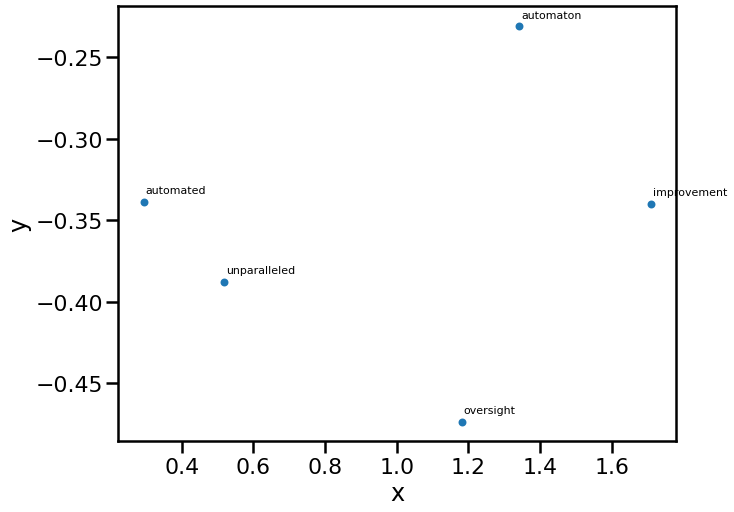

In [73]:
plot_region(x_bounds=(0, 2), y_bounds=(-0.5, -0.1))


In [76]:
cornell2vec.wv.most_similar("spatula")


[('bagel', 0.8759187459945679),
 ('pancake', 0.8719966411590576),
 ('melon', 0.8715268969535828),
 ('foreground', 0.8673826456069946),
 ('Cheeco', 0.8666499853134155),
 ('Irvine', 0.8663395047187805),
 ('mutt', 0.8638278245925903),
 ('gland', 0.8622815608978271),
 ('Curse', 0.8618854880332947),
 ('Boodles', 0.861569881439209)]

In [79]:
cornell2vec.wv['spatula']

array([-2.30165552e-02, -1.77274272e-01, -3.77913862e-02, -1.47590796e-02,
        4.65632826e-02, -4.02910486e-02, -8.72425959e-02, -8.36314932e-02,
       -4.48204279e-02, -6.24632724e-02, -3.36256586e-02, -7.03403354e-02,
        5.12305424e-02,  2.50530373e-02, -7.55838398e-03,  2.71401685e-02,
       -5.75453825e-02,  1.11572094e-01,  2.35099811e-02, -2.97905281e-02,
        3.06959823e-02, -5.47851203e-03, -2.54615936e-02, -1.18864244e-02,
        8.08189884e-02, -7.25261644e-02, -6.46810010e-02,  6.45870809e-03,
        2.45631742e-03, -3.21108401e-02, -3.23558599e-02, -6.79832473e-02,
        4.78695557e-02, -3.82097699e-02, -1.32138021e-02, -5.52157201e-02,
        5.27872145e-02, -8.52275342e-02, -6.17613234e-02, -1.86991622e-03,
       -4.00906466e-02, -9.66985226e-02, -1.01088382e-01,  1.56879395e-01,
        3.05571426e-02, -9.35494620e-03,  5.03624929e-03, -1.85833182e-02,
        4.98349853e-02, -7.64180557e-04,  1.80752650e-02, -1.57025810e-02,
       -7.22242966e-02, -

In [88]:
[cornell2vec.wv[i] for i in sentences[0]]

[array([-4.10534114e-01, -2.26890206e-01, -1.53444678e-01,  2.41525602e-02,
        -1.81920469e-01,  1.77533388e-01, -4.10563529e-01, -1.19511046e-01,
         2.80324966e-01, -3.57708305e-01, -2.02198446e-01, -1.86025336e-01,
        -4.29823771e-02, -3.27550560e-01, -1.38263211e-01,  2.48948872e-01,
        -9.65671614e-02,  6.21088147e-01, -5.00038385e-01,  7.91617855e-02,
        -2.49585941e-01, -6.06550239e-02, -1.99517205e-01,  1.62632868e-01,
        -3.71163011e-01,  1.30792484e-01, -2.21039206e-01,  1.20911613e-01,
        -2.22613186e-01, -1.52128264e-01, -1.61789998e-01, -6.98394030e-02,
         1.43263891e-01,  3.00735887e-02, -3.72008860e-01,  3.32908750e-01,
         2.14043975e-01, -2.70479381e-01, -6.03675902e-01, -2.67543823e-01,
        -8.50161016e-02, -1.86602265e-01, -4.36054505e-02,  3.34971964e-01,
         3.95100325e-01, -1.21797144e-01, -1.01201192e-01, -6.33043721e-02,
         2.36900762e-01,  3.66119862e-01, -3.24947387e-03, -2.13894546e-01,
        -3.6

TODO: Get the tokenized back to the dialog form